In [1]:
# === Part 0: Install dependencies (Lightly) ===
!pip -q install lightly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# === Part 1: Setup & Config ===
import os, math, random, numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Lightly (for SimCLR pretraining option) ----
from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform

# -----------------------
# User toggles
# -----------------------
ENHANCED = False            # set True to try safe boosts later
USE_LIGHTLY_SIMCLR = True   # True: use Lightly SimCLR; False: native SimCLR
DATA_DIR = '/kaggle/input/riceds-original/Original'
SAVE_DIR = './'
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 64
NUM_WORKERS = 4
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# SimCLR pretrain (shared)
SIMCLR_EPOCHS = 100
SIMCLR_LR = 3e-4
SIMCLR_WEIGHT_DECAY = 1e-6
TEMPERATURE = 0.2

# Supervised fine-tune (NO FREEZING)
FINETUNE_EPOCHS = 30
FT_LR_BACKBONE = 1e-4        # lower LR for encoder
FT_LR_HEAD = 1e-3            # higher LR for classifier head
FT_WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.0

USE_IMAGENET_WEIGHTS = True
USE_EMA = True
EMA_DECAY = 0.999
USE_MIXUP = True
MIXUP_ALPHA = 0.2
USE_TTA = True               # eval-time flip TTA

# Enhancements (only if ENHANCED=True)
WARMUP_RATIO = 0.1
USE_BALANCED_SAMPLER = True
TRACK_BN_IN_EMA = True
RUN_KNN_EVAL = True

# Histories
simclr_loss_hist, ft_loss_hist, ft_acc_hist, val_acc_hist = [], [], [], []

# Repro
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
import torch.backends.cudnn as cudnn
cudnn.deterministic = True; cudnn.benchmark = False

print("Device:", DEVICE)
print("Enhanced mode:", ENHANCED)
print("Using Lightly for SimCLR pretraining:", USE_LIGHTLY_SIMCLR)


Device: cuda
Enhanced mode: False
Using Lightly for SimCLR pretraining: True


In [3]:
# === Part 2: Augmentations ===
class TwoCropsTransform:
    """Return two random augmentations of the same image (SimCLR)."""
    def __init__(self, size=224, enhanced=False):
        normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])
        k = int(size * 0.07) // 2 * 2 + 1 if enhanced else 9
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=k, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            normalize,
        ])
    def __call__(self, x):
        return self.transform(x), self.transform(x)

supervised_train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


In [4]:
# === Part 3: Stratified train / val / test split ===
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import datasets
import numpy as np

# Set your desired fractions (must sum to 1.0)
TRAIN_FRAC = 0.70
VAL_FRAC   = 0.10
TEST_FRAC  = 0.20
assert abs(TRAIN_FRAC + VAL_FRAC + TEST_FRAC - 1.0) < 1e-8

_base = datasets.ImageFolder(DATA_DIR, transform=transforms.ToTensor())
labels_all = np.array([lbl for _, lbl in _base.samples])
N = len(labels_all)

def stratified_train_val_test(labels, train_p, val_p, test_p, seed=SEED):
    idx_all = np.arange(len(labels))
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(val_p + test_p), random_state=seed)
    train_idx, hold_idx = next(sss1.split(idx_all, labels))
    hold_labels = labels[hold_idx]
    val_share_in_hold = val_p / (val_p + test_p) if (val_p + test_p) > 0 else 0.0
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=(1.0 - val_share_in_hold), random_state=seed)
    val_rel_idx, test_rel_idx = next(sss2.split(np.arange(len(hold_idx)), hold_labels))
    val_idx  = hold_idx[val_rel_idx]
    test_idx = hold_idx[test_rel_idx]
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = stratified_train_val_test(
    labels_all, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, seed=SEED
)

print(f"Split -> train {int(TRAIN_FRAC*100)}%: {len(train_idx)} | "
      f"val {int(VAL_FRAC*100)}%: {len(val_idx)} | "
      f"test {int(TEST_FRAC*100)}%: {len(test_idx)} | total: {N}")


Split -> train 70%: 13299 | val 10%: 1900 | test 20%: 3801 | total: 19000


In [5]:
# === Part 4: SSL datasets/loaders with SAME indices ===
if USE_LIGHTLY_SIMCLR:
    ssl_dataset = datasets.ImageFolder(
        DATA_DIR,
        transform=SimCLRTransform(input_size=224, gaussian_blur=1.0)
    )
else:
    ssl_dataset = datasets.ImageFolder(
        DATA_DIR,
        transform=TwoCropsTransform(enhanced=ENHANCED)
    )

train_ssl = Subset(ssl_dataset, train_idx)

train_loader_ssl = DataLoader(
    train_ssl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


In [6]:
# === Part 5: Models & Losses ===
class Encoder(nn.Module):
    def __init__(self, use_imagenet=True):
        super().__init__()
        if use_imagenet:
            try:
                base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            except Exception:
                base = models.resnet50(pretrained=True)
        else:
            base = models.resnet50(weights=None)
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # (B, 2048, 1, 1)
        self.feature_dim = 2048
    def forward(self, x):
        x = self.backbone(x)
        return torch.flatten(x, 1)

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, bn_last=False):
        super().__init__()
        layers = [
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim),
        ]
        if bn_last:
            layers.append(nn.BatchNorm1d(out_dim, affine=False))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

class SimCLR_Native(nn.Module):
    def __init__(self, encoder, proj_dim=256, hidden=2048):
        super().__init__()
        self.encoder = encoder
        self.projector = MLP(encoder.feature_dim, hidden, proj_dim, bn_last=True)
    def forward(self, x1, x2):
        h1 = self.encoder(x1); h2 = self.encoder(x2)
        z1 = self.projector(h1); z2 = self.projector(h2)
        return z1, z2

class SimCLR_Lightly(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.projection_head = SimCLRProjectionHead(encoder.feature_dim, 512, 128)
    def forward_single(self, x):
        h = self.encoder(x); z = self.projection_head(h)
        return z
    def forward(self, x1, x2):
        return self.forward_single(x1), self.forward_single(x2)

def nt_xent_loss_native(z1, z2, temperature=0.2):
    b = z1.size(0)
    z1 = F.normalize(z1, dim=1).float()
    z2 = F.normalize(z2, dim=1).float()
    z  = torch.cat([z1, z2], dim=0)
    logits = z @ z.t() / float(temperature)
    eye = torch.eye(2*b, device=z.device, dtype=torch.bool)
    logits.masked_fill_(eye, -1e9)
    targets = (torch.arange(2*b, device=z.device) + b) % (2*b)
    return F.cross_entropy(logits, targets)

class SupModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(encoder.feature_dim, num_classes)
    def forward(self, x):
        feats = self.encoder(x)
        return self.head(feats)


In [7]:
# === Part 6: SimCLR Pretraining (Lightly OR Native) ===
enc_path = os.path.join(SAVE_DIR, "simclr_encoder.pth")

if USE_LIGHTLY_SIMCLR:
    encoder = Encoder(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
    simclr = SimCLR_Lightly(encoder).to(DEVICE)
    criterion = NTXentLoss(temperature=TEMPERATURE)
    optimizer = torch.optim.AdamW(simclr.parameters(), lr=SIMCLR_LR, weight_decay=SIMCLR_WEIGHT_DECAY)

    def cosine_with_warmup(optim, warmup_steps, total_steps):
        def lr_lambda(step):
            if step < warmup_steps: return step / max(1, warmup_steps)
            progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
        return torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda)

    total_steps = SIMCLR_EPOCHS * len(train_loader_ssl)
    warmup_steps = int(WARMUP_RATIO * total_steps) if ENHANCED else 0
    sched = cosine_with_warmup(optimizer, warmup_steps, total_steps) if ENHANCED \
            else torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))
    print("Starting Lightly SimCLR pretraining")
    itercount = 0
    for epoch in range(SIMCLR_EPOCHS):
        simclr.train()
        total_loss = 0.0
        pbar = tqdm(train_loader_ssl, desc=f"Lightly SimCLR {epoch+1}/{SIMCLR_EPOCHS}")
        for batch in pbar:
            x0, x1 = batch[0] if isinstance(batch[0], (tuple, list)) else batch
            x0 = x0.to(DEVICE, non_blocking=True); x1 = x1.to(DEVICE, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
                z0 = simclr.forward_single(x0); z1 = simclr.forward_single(x1)
                loss = criterion(z0, z1)
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            total_loss += float(loss.detach().item())
            itercount += 1; sched.step()
            pbar.set_postfix(loss=f"{total_loss/max(1,pbar.n):.4f}")
        epoch_loss = total_loss / len(train_loader_ssl)
        simclr_loss_hist.append(epoch_loss)
        print(f"Lightly SimCLR Epoch {epoch+1}: loss={epoch_loss:.4f}")
    torch.save(simclr.encoder.state_dict(), enc_path)
    print(f"Saved SimCLR encoder to: {enc_path}")

else:
    encoder = Encoder(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
    simclr = SimCLR_Native(encoder).to(DEVICE)
    ssl_optimizer = torch.optim.AdamW(simclr.parameters(), lr=SIMCLR_LR, weight_decay=SIMCLR_WEIGHT_DECAY)
    ssl_sched = torch.optim.lr_scheduler.CosineAnnealingLR(ssl_optimizer, T_max=SIMCLR_EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

    for epoch in range(SIMCLR_EPOCHS):
        simclr.train(); running = 0.0
        pbar = tqdm(train_loader_ssl, desc=f"SimCLR Epoch {epoch+1}/{SIMCLR_EPOCHS}")
        for ((v1, v2), _) in pbar:
            x1 = v1.to(DEVICE, non_blocking=True); x2 = v2.to(DEVICE, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
                z1, z2 = simclr(x1, x2)
                loss = nt_xent_loss_native(z1, z2, temperature=TEMPERATURE)
            ssl_optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward(); scaler.step(ssl_optimizer); scaler.update()
            running += loss.item(); pbar.set_postfix(loss=f"{running / (pbar.n or 1):.4f}")
        simclr_loss_hist.append(running / len(train_loader_ssl))
        ssl_sched.step()
        print(f"SimCLR Epoch {epoch+1}: loss={simclr_loss_hist[-1]:.4f}")

    torch.save(simclr.encoder.state_dict(), enc_path)
    print(f"Saved SimCLR encoder to: {enc_path}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]
/tmp/ipykernel_19/742682304.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))


Starting Lightly SimCLR pretraining


Lightly SimCLR 1/100:   0%|          | 0/207 [00:00<?, ?it/s]/tmp/ipykernel_19/742682304.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Lightly SimCLR 1/100: 100%|██████████| 207/207 [02:23<00:00,  1.45it/s, loss=2.7410]


Lightly SimCLR Epoch 1: loss=2.7278


Lightly SimCLR 2/100: 100%|██████████| 207/207 [02:18<00:00,  1.49it/s, loss=1.9906]


Lightly SimCLR Epoch 2: loss=1.9810


Lightly SimCLR 3/100: 100%|██████████| 207/207 [02:18<00:00,  1.50it/s, loss=1.7947]


Lightly SimCLR Epoch 3: loss=1.7860


Lightly SimCLR 4/100: 100%|██████████| 207/207 [02:17<00:00,  1.50it/s, loss=1.7128]


Lightly SimCLR Epoch 4: loss=1.7045


Lightly SimCLR 5/100: 100%|██████████| 207/207 [02:17<00:00,  1.50it/s, loss=1.6588]


Lightly SimCLR Epoch 5: loss=1.6508


Lightly SimCLR 6/100: 100%|██████████| 207/207 [02:18<00:00,  1.49it/s, loss=1.6110]


Lightly SimCLR Epoch 6: loss=1.6032


Lightly SimCLR 7/100: 100%|██████████| 207/207 [02:18<00:00,  1.50it/s, loss=1.5673]


Lightly SimCLR Epoch 7: loss=1.5597


Lightly SimCLR 8/100: 100%|██████████| 207/207 [02:18<00:00,  1.50it/s, loss=1.5533]


Lightly SimCLR Epoch 8: loss=1.5458


Lightly SimCLR 9/100: 100%|██████████| 207/207 [02:18<00:00,  1.50it/s, loss=1.5178]


Lightly SimCLR Epoch 9: loss=1.5104


Lightly SimCLR 10/100: 100%|██████████| 207/207 [02:18<00:00,  1.50it/s, loss=1.4918]


Lightly SimCLR Epoch 10: loss=1.4846


Lightly SimCLR 11/100: 100%|██████████| 207/207 [02:18<00:00,  1.49it/s, loss=1.4638]


Lightly SimCLR Epoch 11: loss=1.4567


Lightly SimCLR 12/100: 100%|██████████| 207/207 [02:18<00:00,  1.50it/s, loss=1.4536]


Lightly SimCLR Epoch 12: loss=1.4465


Lightly SimCLR 13/100: 100%|██████████| 207/207 [02:18<00:00,  1.50it/s, loss=1.4374]


Lightly SimCLR Epoch 13: loss=1.4305


Lightly SimCLR 14/100: 100%|██████████| 207/207 [02:19<00:00,  1.48it/s, loss=1.4322]


Lightly SimCLR Epoch 14: loss=1.4253


Lightly SimCLR 15/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.4202]


Lightly SimCLR Epoch 15: loss=1.4134


Lightly SimCLR 16/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.4084]


Lightly SimCLR Epoch 16: loss=1.4016


Lightly SimCLR 17/100: 100%|██████████| 207/207 [02:29<00:00,  1.38it/s, loss=1.3871]


Lightly SimCLR Epoch 17: loss=1.3804


Lightly SimCLR 18/100: 100%|██████████| 207/207 [02:38<00:00,  1.30it/s, loss=1.3773]


Lightly SimCLR Epoch 18: loss=1.3707


Lightly SimCLR 19/100: 100%|██████████| 207/207 [02:40<00:00,  1.29it/s, loss=1.3693]


Lightly SimCLR Epoch 19: loss=1.3627


Lightly SimCLR 20/100: 100%|██████████| 207/207 [02:42<00:00,  1.27it/s, loss=1.3540]


Lightly SimCLR Epoch 20: loss=1.3475


Lightly SimCLR 21/100: 100%|██████████| 207/207 [02:36<00:00,  1.33it/s, loss=1.3450]


Lightly SimCLR Epoch 21: loss=1.3385


Lightly SimCLR 22/100: 100%|██████████| 207/207 [02:32<00:00,  1.36it/s, loss=1.3580]


Lightly SimCLR Epoch 22: loss=1.3514


Lightly SimCLR 23/100: 100%|██████████| 207/207 [02:31<00:00,  1.37it/s, loss=1.3281]


Lightly SimCLR Epoch 23: loss=1.3217


Lightly SimCLR 24/100: 100%|██████████| 207/207 [02:39<00:00,  1.30it/s, loss=1.3248]


Lightly SimCLR Epoch 24: loss=1.3184


Lightly SimCLR 25/100: 100%|██████████| 207/207 [02:41<00:00,  1.28it/s, loss=1.3132]


Lightly SimCLR Epoch 25: loss=1.3068


Lightly SimCLR 26/100: 100%|██████████| 207/207 [02:44<00:00,  1.25it/s, loss=1.3180]


Lightly SimCLR Epoch 26: loss=1.3117


Lightly SimCLR 27/100: 100%|██████████| 207/207 [02:42<00:00,  1.27it/s, loss=1.2885]


Lightly SimCLR Epoch 27: loss=1.2823


Lightly SimCLR 28/100: 100%|██████████| 207/207 [02:36<00:00,  1.32it/s, loss=1.2937]


Lightly SimCLR Epoch 28: loss=1.2874


Lightly SimCLR 29/100: 100%|██████████| 207/207 [02:26<00:00,  1.42it/s, loss=1.3005]


Lightly SimCLR Epoch 29: loss=1.2942


Lightly SimCLR 30/100: 100%|██████████| 207/207 [02:27<00:00,  1.41it/s, loss=1.2908]


Lightly SimCLR Epoch 30: loss=1.2845


Lightly SimCLR 31/100: 100%|██████████| 207/207 [02:22<00:00,  1.45it/s, loss=1.2926]


Lightly SimCLR Epoch 31: loss=1.2864


Lightly SimCLR 32/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.2745]


Lightly SimCLR Epoch 32: loss=1.2683


Lightly SimCLR 33/100: 100%|██████████| 207/207 [02:18<00:00,  1.49it/s, loss=1.2767]


Lightly SimCLR Epoch 33: loss=1.2705


Lightly SimCLR 34/100: 100%|██████████| 207/207 [02:19<00:00,  1.49it/s, loss=1.2564]


Lightly SimCLR Epoch 34: loss=1.2503


Lightly SimCLR 35/100: 100%|██████████| 207/207 [02:18<00:00,  1.49it/s, loss=1.2531]


Lightly SimCLR Epoch 35: loss=1.2470


Lightly SimCLR 36/100: 100%|██████████| 207/207 [02:19<00:00,  1.49it/s, loss=1.2474]


Lightly SimCLR Epoch 36: loss=1.2414


Lightly SimCLR 37/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.2380]


Lightly SimCLR Epoch 37: loss=1.2320


Lightly SimCLR 38/100: 100%|██████████| 207/207 [02:29<00:00,  1.38it/s, loss=1.2317]


Lightly SimCLR Epoch 38: loss=1.2257


Lightly SimCLR 39/100: 100%|██████████| 207/207 [02:34<00:00,  1.34it/s, loss=1.2335]


Lightly SimCLR Epoch 39: loss=1.2275


Lightly SimCLR 40/100: 100%|██████████| 207/207 [02:23<00:00,  1.44it/s, loss=1.2291]


Lightly SimCLR Epoch 40: loss=1.2232


Lightly SimCLR 41/100: 100%|██████████| 207/207 [02:24<00:00,  1.43it/s, loss=1.2283]


Lightly SimCLR Epoch 41: loss=1.2223


Lightly SimCLR 42/100: 100%|██████████| 207/207 [02:29<00:00,  1.38it/s, loss=1.2175]


Lightly SimCLR Epoch 42: loss=1.2116


Lightly SimCLR 43/100: 100%|██████████| 207/207 [02:22<00:00,  1.45it/s, loss=1.2263]


Lightly SimCLR Epoch 43: loss=1.2204


Lightly SimCLR 44/100: 100%|██████████| 207/207 [02:34<00:00,  1.34it/s, loss=1.2006]


Lightly SimCLR Epoch 44: loss=1.1948


Lightly SimCLR 45/100: 100%|██████████| 207/207 [02:26<00:00,  1.41it/s, loss=1.2062]


Lightly SimCLR Epoch 45: loss=1.2004


Lightly SimCLR 46/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1954]


Lightly SimCLR Epoch 46: loss=1.1897


Lightly SimCLR 47/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1964]


Lightly SimCLR Epoch 47: loss=1.1906


Lightly SimCLR 48/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1915]


Lightly SimCLR Epoch 48: loss=1.1857


Lightly SimCLR 49/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1786]


Lightly SimCLR Epoch 49: loss=1.1729


Lightly SimCLR 50/100: 100%|██████████| 207/207 [02:20<00:00,  1.48it/s, loss=1.1731]


Lightly SimCLR Epoch 50: loss=1.1675


Lightly SimCLR 51/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1678]


Lightly SimCLR Epoch 51: loss=1.1622


Lightly SimCLR 52/100: 100%|██████████| 207/207 [02:22<00:00,  1.46it/s, loss=1.1718]


Lightly SimCLR Epoch 52: loss=1.1662


Lightly SimCLR 53/100: 100%|██████████| 207/207 [02:21<00:00,  1.47it/s, loss=1.1768]


Lightly SimCLR Epoch 53: loss=1.1711


Lightly SimCLR 54/100: 100%|██████████| 207/207 [02:21<00:00,  1.47it/s, loss=1.1637]


Lightly SimCLR Epoch 54: loss=1.1581


Lightly SimCLR 55/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1525]


Lightly SimCLR Epoch 55: loss=1.1470


Lightly SimCLR 56/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1495]


Lightly SimCLR Epoch 56: loss=1.1440


Lightly SimCLR 57/100: 100%|██████████| 207/207 [02:21<00:00,  1.46it/s, loss=1.1501]


Lightly SimCLR Epoch 57: loss=1.1445


Lightly SimCLR 58/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1399]


Lightly SimCLR Epoch 58: loss=1.1344


Lightly SimCLR 59/100: 100%|██████████| 207/207 [02:21<00:00,  1.46it/s, loss=1.1495]


Lightly SimCLR Epoch 59: loss=1.1440


Lightly SimCLR 60/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1385]


Lightly SimCLR Epoch 60: loss=1.1330


Lightly SimCLR 61/100: 100%|██████████| 207/207 [02:21<00:00,  1.46it/s, loss=1.1375]


Lightly SimCLR Epoch 61: loss=1.1320


Lightly SimCLR 62/100: 100%|██████████| 207/207 [02:20<00:00,  1.48it/s, loss=1.1297]


Lightly SimCLR Epoch 62: loss=1.1243


Lightly SimCLR 63/100: 100%|██████████| 207/207 [02:19<00:00,  1.48it/s, loss=1.1223]


Lightly SimCLR Epoch 63: loss=1.1169


Lightly SimCLR 64/100: 100%|██████████| 207/207 [02:22<00:00,  1.45it/s, loss=1.1211]


Lightly SimCLR Epoch 64: loss=1.1156


Lightly SimCLR 65/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1147]


Lightly SimCLR Epoch 65: loss=1.1093


Lightly SimCLR 66/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1096]


Lightly SimCLR Epoch 66: loss=1.1043


Lightly SimCLR 67/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1058]


Lightly SimCLR Epoch 67: loss=1.1004


Lightly SimCLR 68/100: 100%|██████████| 207/207 [02:21<00:00,  1.46it/s, loss=1.1034]


Lightly SimCLR Epoch 68: loss=1.0981


Lightly SimCLR 69/100: 100%|██████████| 207/207 [02:21<00:00,  1.46it/s, loss=1.1022]


Lightly SimCLR Epoch 69: loss=1.0969


Lightly SimCLR 70/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.1001]


Lightly SimCLR Epoch 70: loss=1.0948


Lightly SimCLR 71/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.0976]


Lightly SimCLR Epoch 71: loss=1.0923


Lightly SimCLR 72/100: 100%|██████████| 207/207 [02:21<00:00,  1.46it/s, loss=1.0926]


Lightly SimCLR Epoch 72: loss=1.0873


Lightly SimCLR 73/100: 100%|██████████| 207/207 [02:22<00:00,  1.45it/s, loss=1.1031]


Lightly SimCLR Epoch 73: loss=1.0978


Lightly SimCLR 74/100: 100%|██████████| 207/207 [02:22<00:00,  1.45it/s, loss=1.0794]


Lightly SimCLR Epoch 74: loss=1.0742


Lightly SimCLR 75/100: 100%|██████████| 207/207 [02:22<00:00,  1.46it/s, loss=1.0958]


Lightly SimCLR Epoch 75: loss=1.0905


Lightly SimCLR 76/100: 100%|██████████| 207/207 [02:21<00:00,  1.46it/s, loss=1.0829]


Lightly SimCLR Epoch 76: loss=1.0777


Lightly SimCLR 77/100: 100%|██████████| 207/207 [02:21<00:00,  1.47it/s, loss=1.0811]


Lightly SimCLR Epoch 77: loss=1.0759


Lightly SimCLR 78/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.0684]


Lightly SimCLR Epoch 78: loss=1.0632


Lightly SimCLR 79/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.0843]


Lightly SimCLR Epoch 79: loss=1.0790


Lightly SimCLR 80/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.0769]


Lightly SimCLR Epoch 80: loss=1.0717


Lightly SimCLR 81/100: 100%|██████████| 207/207 [02:21<00:00,  1.46it/s, loss=1.0676]


Lightly SimCLR Epoch 81: loss=1.0625


Lightly SimCLR 82/100: 100%|██████████| 207/207 [02:20<00:00,  1.47it/s, loss=1.0704]


Lightly SimCLR Epoch 82: loss=1.0652


Lightly SimCLR 83/100: 100%|██████████| 207/207 [02:21<00:00,  1.46it/s, loss=1.0599]


Lightly SimCLR Epoch 83: loss=1.0548


Lightly SimCLR 84/100: 100%|██████████| 207/207 [02:21<00:00,  1.46it/s, loss=1.0551]


Lightly SimCLR Epoch 84: loss=1.0500


Lightly SimCLR 85/100: 100%|██████████| 207/207 [02:25<00:00,  1.42it/s, loss=1.0607]


Lightly SimCLR Epoch 85: loss=1.0556


Lightly SimCLR 86/100: 100%|██████████| 207/207 [02:24<00:00,  1.43it/s, loss=1.0600]


Lightly SimCLR Epoch 86: loss=1.0549


Lightly SimCLR 87/100: 100%|██████████| 207/207 [02:22<00:00,  1.46it/s, loss=1.0626]


Lightly SimCLR Epoch 87: loss=1.0575


Lightly SimCLR 88/100: 100%|██████████| 207/207 [02:22<00:00,  1.45it/s, loss=1.0634]


Lightly SimCLR Epoch 88: loss=1.0582


Lightly SimCLR 89/100: 100%|██████████| 207/207 [02:22<00:00,  1.45it/s, loss=1.0589]


Lightly SimCLR Epoch 89: loss=1.0538


Lightly SimCLR 90/100: 100%|██████████| 207/207 [02:24<00:00,  1.43it/s, loss=1.0575]


Lightly SimCLR Epoch 90: loss=1.0524


Lightly SimCLR 91/100: 100%|██████████| 207/207 [02:23<00:00,  1.44it/s, loss=1.0723]


Lightly SimCLR Epoch 91: loss=1.0671


Lightly SimCLR 92/100: 100%|██████████| 207/207 [02:23<00:00,  1.44it/s, loss=1.0605]


Lightly SimCLR Epoch 92: loss=1.0553


Lightly SimCLR 93/100: 100%|██████████| 207/207 [02:23<00:00,  1.44it/s, loss=1.0459]


Lightly SimCLR Epoch 93: loss=1.0408


Lightly SimCLR 94/100: 100%|██████████| 207/207 [02:23<00:00,  1.44it/s, loss=1.0583]


Lightly SimCLR Epoch 94: loss=1.0532


Lightly SimCLR 95/100: 100%|██████████| 207/207 [02:22<00:00,  1.45it/s, loss=1.0640]


Lightly SimCLR Epoch 95: loss=1.0588


Lightly SimCLR 96/100: 100%|██████████| 207/207 [02:22<00:00,  1.45it/s, loss=1.0491]


Lightly SimCLR Epoch 96: loss=1.0441


Lightly SimCLR 97/100: 100%|██████████| 207/207 [02:22<00:00,  1.45it/s, loss=1.0624]


Lightly SimCLR Epoch 97: loss=1.0573


Lightly SimCLR 98/100: 100%|██████████| 207/207 [02:23<00:00,  1.44it/s, loss=1.0499]


Lightly SimCLR Epoch 98: loss=1.0448


Lightly SimCLR 99/100: 100%|██████████| 207/207 [02:23<00:00,  1.44it/s, loss=1.0524]


Lightly SimCLR Epoch 99: loss=1.0473


Lightly SimCLR 100/100: 100%|██████████| 207/207 [02:23<00:00,  1.45it/s, loss=1.0475]


Lightly SimCLR Epoch 100: loss=1.0425
Saved SimCLR encoder to: ./simclr_encoder.pth


In [8]:
# === Part 7: Supervised Fine-Tuning (EMA + MixUp + TTA) — train/val/test ===
sup_train_ds = datasets.ImageFolder(DATA_DIR, transform=supervised_train_tf)
sup_val_ds   = datasets.ImageFolder(DATA_DIR, transform=eval_tf)
sup_test_ds  = datasets.ImageFolder(DATA_DIR, transform=eval_tf)
num_classes  = len(sup_train_ds.classes)

train_sup = Subset(sup_train_ds, train_idx)
val_sup   = Subset(sup_val_ds,  val_idx)
test_sup  = Subset(sup_test_ds, test_idx)

if ENHANCED and USE_BALANCED_SAMPLER:
    targets = np.array([sup_train_ds.samples[i][1] for i in train_idx])
    class_counts = np.bincount(targets, minlength=num_classes).astype(float)
    class_weights = 1.0 / np.maximum(class_counts, 1.0)
    sample_weights = class_weights[targets]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader_sup = DataLoader(train_sup, batch_size=BATCH_SIZE, sampler=sampler,
                                  num_workers=NUM_WORKERS, pin_memory=True)
else:
    train_loader_sup = DataLoader(train_sup, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, pin_memory=True)
val_loader_sup  = DataLoader(val_sup,  batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=True)
test_loader_sup = DataLoader(test_sup, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=True)

class EMA:
    def __init__(self, model, decay=EMA_DECAY, track_bn=(ENHANCED and TRACK_BN_IN_EMA)):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items()
                       if v.dtype.is_floating_point and (track_bn or 'running' not in k)}
    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1-self.decay)
    @torch.no_grad()
    def copy_to(self, model):
        sd = model.state_dict()
        for k, v in self.shadow.items(): sd[k].copy_(v)

def one_hot_with_smoothing(y, num_classes, eps=0.0):
    y = y.view(-1)
    oh = torch.zeros(y.size(0), num_classes, device=y.device)
    oh.scatter_(1, y.unsqueeze(1), 1.0)
    if eps > 0: oh = oh * (1 - eps) + eps / num_classes
    return oh

def mixup_data(x, y, alpha=MIXUP_ALPHA, num_classes=num_classes, eps=LABEL_SMOOTH):
    if not USE_MIXUP or alpha <= 0:
        return x, one_hot_with_smoothing(y, num_classes, eps), 1.0
    lam = np.random.beta(alpha, alpha); idx = torch.randperm(x.size(0), device=x.device)
    xm = lam*x + (1-lam)*x[idx]
    y1 = one_hot_with_smoothing(y, num_classes, eps); y2 = y1[idx]
    ym = lam*y1 + (1-lam)*y2
    return xm, ym, lam

def soft_cross_entropy(logits, target_prob):
    return -(target_prob * F.log_softmax(logits, dim=1)).sum(dim=1).mean()

def accuracy_top1(logits, targets):
    return (logits.argmax(dim=1) == targets).float().mean().item()

def predict_tta(model, x):
    logits1 = model(x)
    logits2 = model(torch.flip(x, dims=[3])) if USE_TTA else 0
    return (logits1 + logits2) / (2 if USE_TTA else 1)

# Build model from pretrained encoder
finetune_encoder = Encoder(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
finetune_encoder.load_state_dict(torch.load(os.path.join(SAVE_DIR, "simclr_encoder.pth"), map_location=DEVICE))
sup_model = SupModel(finetune_encoder, num_classes).to(DEVICE)

param_groups = [
    {"params": sup_model.encoder.parameters(), "lr": FT_LR_BACKBONE, "weight_decay": FT_WEIGHT_DECAY},
    {"params": sup_model.head.parameters(),    "lr": FT_LR_HEAD,     "weight_decay": FT_WEIGHT_DECAY},
]
ft_optimizer = torch.optim.AdamW(param_groups)

def cosine_with_warmup(optimizer, warmup_steps, total_steps):
    def lr_lambda(step):
        if step < warmup_steps: return step / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

if ENHANCED:
    total_steps = FINETUNE_EPOCHS * len(train_loader_sup)
    warmup_steps = int(WARMUP_RATIO * total_steps)
    ft_sched = cosine_with_warmup(ft_optimizer, warmup_steps, total_steps)
else:
    ft_sched = torch.optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max=FINETUNE_EPOCHS)

ema = EMA(sup_model) if USE_EMA else None
scaler_ft = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))

best_acc = 0.0
best_path = os.path.join(SAVE_DIR, "simclr_finetune_best.pt")

for epoch in range(FINETUNE_EPOCHS):
    sup_model.train(); run_loss, run_acc = 0.0, 0.0
    pbar = tqdm(train_loader_sup, desc=f"FT Epoch {epoch+1}/{FINETUNE_EPOCHS}")
    for i, (x, y) in enumerate(pbar, start=1):
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        x_in, y_soft, _ = mixup_data(x, y)

        with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
            logits = sup_model(x_in)
            loss = soft_cross_entropy(logits, y_soft)

        ft_optimizer.zero_grad(set_to_none=True)
        scaler_ft.scale(loss).backward()
        if ENHANCED: scaler_ft.unscale_(ft_optimizer)
        torch.nn.utils.clip_grad_norm_(sup_model.parameters(), 5.0)
        scaler_ft.step(ft_optimizer); scaler_ft.update()

        if USE_EMA: ema.update(sup_model)
        with torch.no_grad():
            run_acc += accuracy_top1(sup_model(x), y)
        run_loss += loss.item()
        pbar.set_postfix(loss=f"{run_loss/i:.4f}", acc=f"{(run_acc/i):.4f}")
        if ENHANCED: ft_sched.step()

    ft_loss_hist.append(run_loss / len(train_loader_sup))
    ft_acc_hist.append(run_acc / len(train_loader_sup))
    if not ENHANCED: ft_sched.step()
    print(f"[FT] Epoch {epoch+1}: loss={ft_loss_hist[-1]:.4f} | acc={ft_acc_hist[-1]:.4f}")

    # ---- Eval on VALIDATION each epoch ----
    sup_model.eval()
    backup = {k: v.detach().clone() for k, v in sup_model.state_dict().items() if v.dtype.is_floating_point}
    if USE_EMA: ema.copy_to(sup_model)

    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader_sup:
            x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            logits = predict_tta(sup_model, x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    epoch_acc = correct / max(total, 1)
    val_acc_hist.append(epoch_acc)

    sd = sup_model.state_dict()
    for k, v in backup.items(): sd[k].copy_(v)

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        if USE_EMA:
            ema.copy_to(sup_model); torch.save(sup_model.state_dict(), best_path)
            for k, v in backup.items(): sd[k].copy_(v)
        else:
            torch.save(sup_model.state_dict(), best_path)

    print(f"[Eval-VAL] top1={epoch_acc:.4f} (best={best_acc:.4f})")


/tmp/ipykernel_19/1898125084.py:95: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_ft = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == 'cuda'))
FT Epoch 1/30:   0%|          | 0/208 [00:00<?, ?it/s]/tmp/ipykernel_19/1898125084.py:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == 'cuda')):
FT Epoch 1/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.4894, loss=2.0571]

[FT] Epoch 1: loss=2.0571 | acc=0.4894


[Eval-VAL] top1=0.1868 (best=0.1868)


FT Epoch 2/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.7317, loss=1.3540]

[FT] Epoch 2: loss=1.3540 | acc=0.7317


[Eval-VAL] top1=0.3221 (best=0.3221)


FT Epoch 3/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.8184, loss=1.0928]

[FT] Epoch 3: loss=1.0928 | acc=0.8184


[Eval-VAL] top1=0.3821 (best=0.3821)


FT Epoch 4/30: 100%|██████████| 208/208 [01:26<00:00,  2.40it/s, acc=0.8621, loss=1.0131]

[FT] Epoch 4: loss=1.0131 | acc=0.8621


[Eval-VAL] top1=0.3974 (best=0.3974)


FT Epoch 5/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.8899, loss=0.9002]

[FT] Epoch 5: loss=0.9002 | acc=0.8899


[Eval-VAL] top1=0.5042 (best=0.5042)


FT Epoch 6/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9117, loss=0.8262]

[FT] Epoch 6: loss=0.8262 | acc=0.9117


[Eval-VAL] top1=0.5000 (best=0.5042)


FT Epoch 7/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9272, loss=0.7387]

[FT] Epoch 7: loss=0.7387 | acc=0.9272


[Eval-VAL] top1=0.6263 (best=0.6263)


FT Epoch 8/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9367, loss=0.8071]

[FT] Epoch 8: loss=0.8071 | acc=0.9367


[Eval-VAL] top1=0.6853 (best=0.6853)


FT Epoch 9/30: 100%|██████████| 208/208 [01:26<00:00,  2.40it/s, acc=0.9440, loss=0.6604]

[FT] Epoch 9: loss=0.6604 | acc=0.9440


[Eval-VAL] top1=0.7316 (best=0.7316)


FT Epoch 10/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9519, loss=0.7088]

[FT] Epoch 10: loss=0.7088 | acc=0.9519


[Eval-VAL] top1=0.7437 (best=0.7437)


FT Epoch 11/30: 100%|██████████| 208/208 [01:26<00:00,  2.42it/s, acc=0.9607, loss=0.7100]

[FT] Epoch 11: loss=0.7100 | acc=0.9607


[Eval-VAL] top1=0.7605 (best=0.7605)


FT Epoch 12/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9653, loss=0.6105]

[FT] Epoch 12: loss=0.6105 | acc=0.9653


[Eval-VAL] top1=0.8174 (best=0.8174)


FT Epoch 13/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9683, loss=0.6321]

[FT] Epoch 13: loss=0.6321 | acc=0.9683


[Eval-VAL] top1=0.8184 (best=0.8184)


FT Epoch 14/30: 100%|██████████| 208/208 [01:26<00:00,  2.40it/s, acc=0.9716, loss=0.5417]

[FT] Epoch 14: loss=0.5417 | acc=0.9716


[Eval-VAL] top1=0.8100 (best=0.8184)


FT Epoch 15/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9789, loss=0.5511]

[FT] Epoch 15: loss=0.5511 | acc=0.9789


[Eval-VAL] top1=0.8463 (best=0.8463)


FT Epoch 16/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9785, loss=0.5466]

[FT] Epoch 16: loss=0.5466 | acc=0.9785


[Eval-VAL] top1=0.8642 (best=0.8642)


FT Epoch 17/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9817, loss=0.5088]

[FT] Epoch 17: loss=0.5088 | acc=0.9817


[Eval-VAL] top1=0.8816 (best=0.8816)


FT Epoch 18/30: 100%|██████████| 208/208 [01:26<00:00,  2.40it/s, acc=0.9847, loss=0.5447]

[FT] Epoch 18: loss=0.5447 | acc=0.9847


[Eval-VAL] top1=0.8826 (best=0.8826)


FT Epoch 19/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9848, loss=0.4868]

[FT] Epoch 19: loss=0.4868 | acc=0.9848


[Eval-VAL] top1=0.8758 (best=0.8826)


FT Epoch 20/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9856, loss=0.5067]

[FT] Epoch 20: loss=0.5067 | acc=0.9856


[Eval-VAL] top1=0.9016 (best=0.9016)


FT Epoch 21/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9866, loss=0.5433]

[FT] Epoch 21: loss=0.5433 | acc=0.9866


[Eval-VAL] top1=0.9132 (best=0.9132)


FT Epoch 22/30: 100%|██████████| 208/208 [01:26<00:00,  2.40it/s, acc=0.9899, loss=0.5405]

[FT] Epoch 22: loss=0.5405 | acc=0.9899


[Eval-VAL] top1=0.9147 (best=0.9147)


FT Epoch 23/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9883, loss=0.5475]

[FT] Epoch 23: loss=0.5475 | acc=0.9883


[Eval-VAL] top1=0.9195 (best=0.9195)


FT Epoch 24/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9901, loss=0.5253]

[FT] Epoch 24: loss=0.5253 | acc=0.9901


[Eval-VAL] top1=0.9258 (best=0.9258)


FT Epoch 25/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9922, loss=0.5276]

[FT] Epoch 25: loss=0.5276 | acc=0.9922


[Eval-VAL] top1=0.9205 (best=0.9258)


FT Epoch 26/30: 100%|██████████| 208/208 [01:26<00:00,  2.40it/s, acc=0.9933, loss=0.4675]

[FT] Epoch 26: loss=0.4675 | acc=0.9933


[Eval-VAL] top1=0.9221 (best=0.9258)


FT Epoch 27/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9930, loss=0.4625]

[FT] Epoch 27: loss=0.4625 | acc=0.9930


[Eval-VAL] top1=0.9326 (best=0.9326)


FT Epoch 28/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9924, loss=0.4475]

[FT] Epoch 28: loss=0.4475 | acc=0.9924


[Eval-VAL] top1=0.9368 (best=0.9368)


FT Epoch 29/30: 100%|██████████| 208/208 [01:26<00:00,  2.41it/s, acc=0.9935, loss=0.4806]

[FT] Epoch 29: loss=0.4806 | acc=0.9935


[Eval-VAL] top1=0.9379 (best=0.9379)


FT Epoch 30/30: 100%|██████████| 208/208 [01:26<00:00,  2.40it/s, acc=0.9932, loss=0.5471]

[FT] Epoch 30: loss=0.5471 | acc=0.9932


[Eval-VAL] top1=0.9347 (best=0.9379)


In [9]:
# === Part 8 (Optional): k-NN eval on features ===
if ENHANCED and RUN_KNN_EVAL:
    @torch.no_grad()
    def extract_feats(model, loader, device):
        model.eval()
        feats, labels = [], []
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            f = model.encoder(x)
            f = F.normalize(f, dim=1)
            feats.append(f.cpu()); labels.append(y)
        return torch.cat(feats), torch.cat(labels)

    from sklearn.neighbors import KNeighborsClassifier
    train_feats, train_y = extract_feats(sup_model, train_loader_sup, DEVICE)
    val_feats,   val_y   = extract_feats(sup_model, val_loader_sup,  DEVICE)
    knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
    knn.fit(train_feats.numpy(), train_y.numpy())
    print("kNN top-1 (val):", knn.score(val_feats.numpy(), val_y.numpy()))



=== SimCLR -> End-to-End Fine-Tune: Held-out Test ===
              precision    recall  f1-score   support

        BD30     0.7742    0.9600    0.8571       100
        BD33     0.9785    0.9100    0.9430       100
        BD39     1.0000    0.9600    0.9796       100
        BD49     0.8941    0.7600    0.8216       100
        BD51     0.9592    0.9400    0.9495       100
        BD52     0.8362    0.9700    0.8981       100
        BD56     0.9314    0.9500    0.9406       100
        BD57     0.9900    0.9900    0.9900       100
        BD70     0.9231    0.9600    0.9412       100
        BD72     0.9615    1.0000    0.9804       100
        BD75     0.9398    0.7800    0.8525       100
        BD76     0.9899    0.9800    0.9849       100
        BD79     0.9314    0.9500    0.9406       100
        BD85     0.9223    0.9500    0.9360       100
        BD87     1.0000    0.9800    0.9899       100
        BD91     0.9700    0.9700    0.9700       100
        BD93     0.9789   

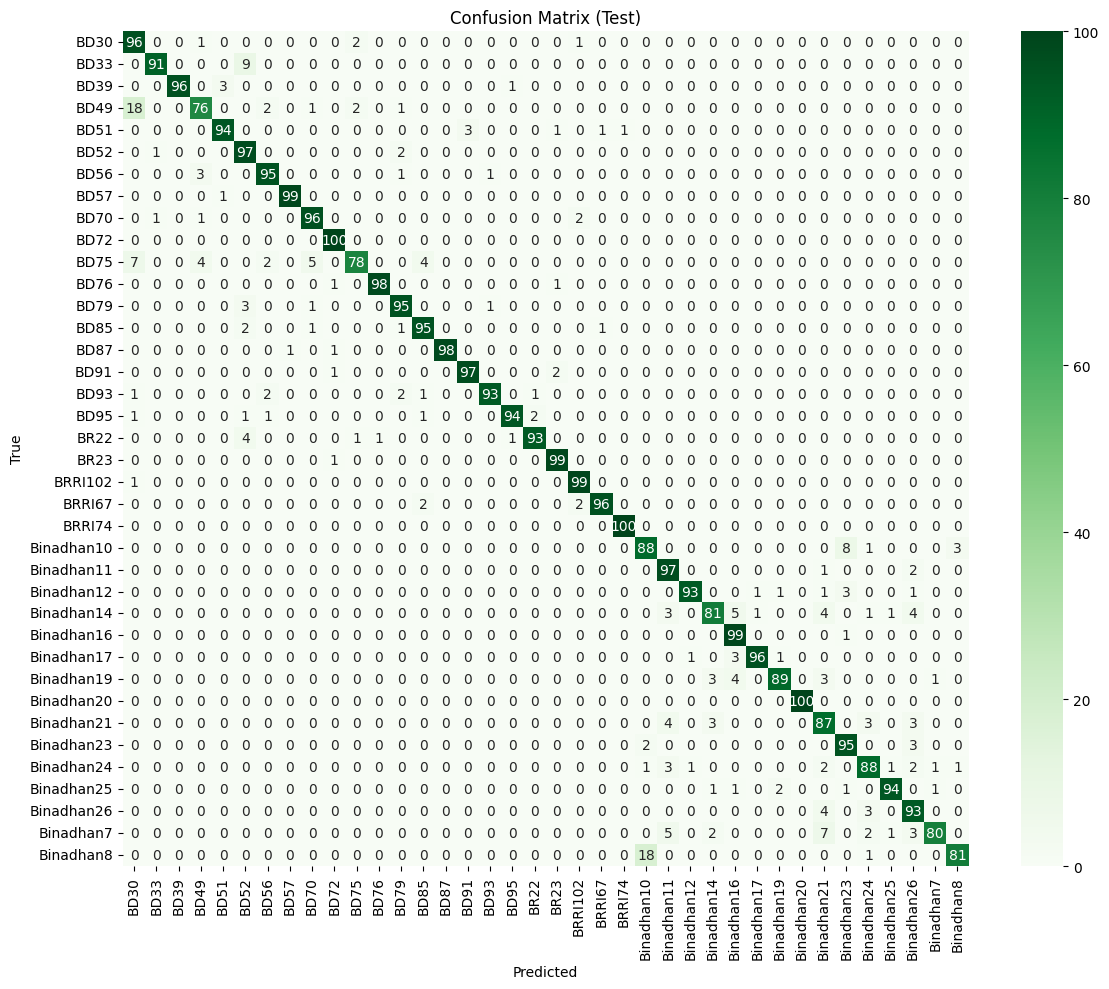

In [10]:
# === Part 9: Final evaluation on held-out TEST (EMA best) ===
finetune_encoder = Encoder(use_imagenet=USE_IMAGENET_WEIGHTS).to(DEVICE)
enc_path = os.path.join(SAVE_DIR, "simclr_encoder.pth")
best_path = os.path.join(SAVE_DIR, "simclr_finetune_best.pt")

finetune_encoder.load_state_dict(torch.load(enc_path, map_location=DEVICE))
sup_model = SupModel(finetune_encoder, num_classes).to(DEVICE)
sup_model.load_state_dict(torch.load(best_path, map_location=DEVICE))
sup_model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader_sup:
        x = x.to(DEVICE, non_blocking=True)
        logits = (predict_tta(sup_model, x) if USE_TTA else sup_model(x))
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.extend(preds); y_true.extend(y.numpy())

print("\n=== SimCLR -> End-to-End Fine-Tune: Held-out Test ===")
print(classification_report(y_true, y_pred, target_names=sup_test_ds.classes, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=sup_test_ds.classes, yticklabels=sup_test_ds.classes)
plt.title("Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.savefig(os.path.join(SAVE_DIR, "simclr_confusion_matrix.png"), dpi=150)
plt.show()


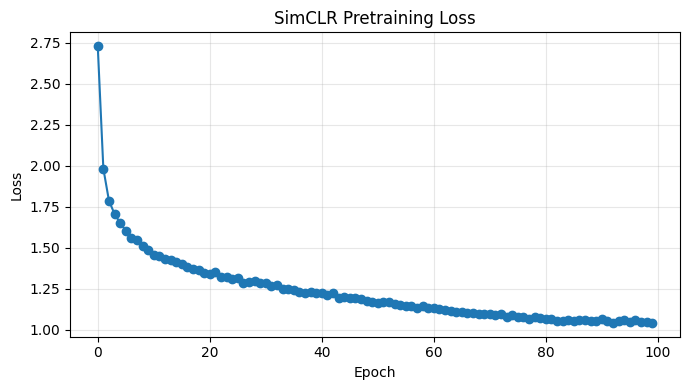

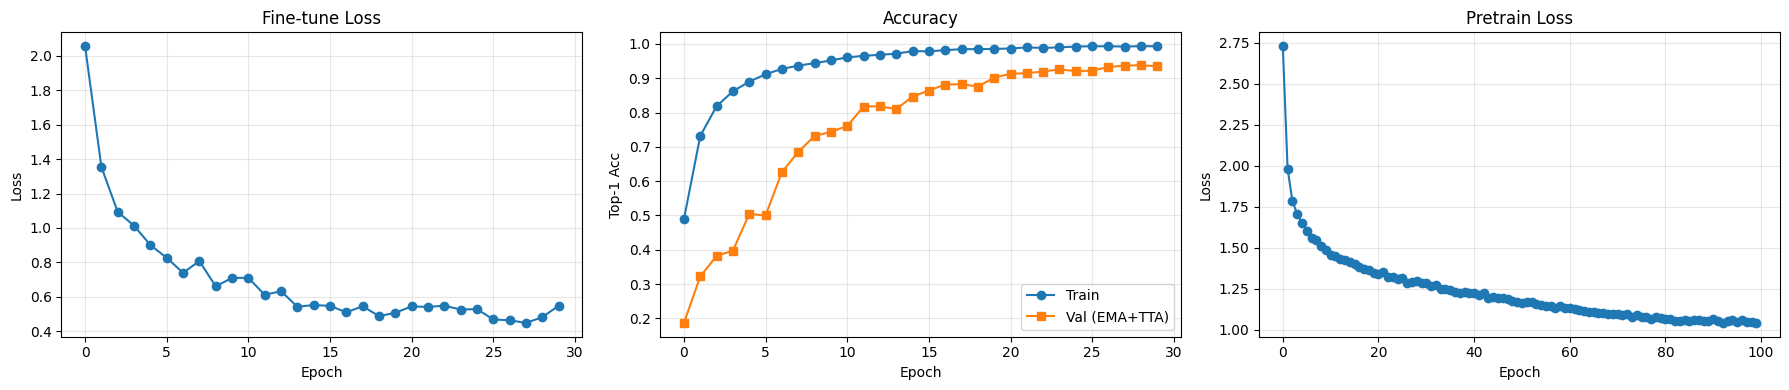

In [11]:
# === Part 10: Training Curves ===
plt.figure(figsize=(7,4))
plt.plot(simclr_loss_hist, marker='o')
plt.title("SimCLR Pretraining Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "simclr_pretrain_loss.png"), dpi=150)
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18,4))
ax[0].plot(ft_loss_hist, marker='o')
ax[0].set_title("Fine-tune Loss"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss"); ax[0].grid(True, alpha=0.3)

ax[1].plot(ft_acc_hist, marker='o', label='Train')
ax[1].plot(val_acc_hist, marker='s', label='Val (EMA+TTA)')
ax[1].set_title("Accuracy"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Top-1 Acc"); ax[1].grid(True, alpha=0.3); ax[1].legend()

ax[2].plot(simclr_loss_hist, marker='o')
ax[2].set_title("Pretrain Loss"); ax[2].set_xlabel("Epoch"); ax[2].set_ylabel("Loss"); ax[2].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(os.path.join(SAVE_DIR, "simclr_training_curves.png"), dpi=150)
plt.show()


In [12]:
# === Part 11: Gather predictions, probabilities, and class names ===
import numpy as np
import torch.nn.functional as F

sup_model.eval()
class_names = sup_test_ds.classes
num_classes = len(class_names)

all_probs, all_preds, all_targets = [], [], []

with torch.no_grad():
    for x, y in test_loader_sup:
        x = x.to(DEVICE, non_blocking=True)
        logits = (predict_tta(sup_model, x) if USE_TTA else sup_model(x))
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        preds  = np.argmax(probs, axis=1)
        all_probs.append(probs); all_preds.append(preds); all_targets.append(y.numpy())

y_prob = np.concatenate(all_probs, axis=0)      # (N, C)
y_pred = np.concatenate(all_preds, axis=0)      # (N,)
y_true = np.concatenate(all_targets, axis=0)    # (N,)

print("Shapes -> y_prob:", y_prob.shape, "| y_pred:", y_pred.shape, "| y_true:", y_true.shape)
print("Classes:", class_names)


Shapes -> y_prob: (3801, 38) | y_pred: (3801,) | y_true: (3801,)
Classes: ['BD30', 'BD33', 'BD39', 'BD49', 'BD51', 'BD52', 'BD56', 'BD57', 'BD70', 'BD72', 'BD75', 'BD76', 'BD79', 'BD85', 'BD87', 'BD91', 'BD93', 'BD95', 'BR22', 'BR23', 'BRRI102', 'BRRI67', 'BRRI74', 'Binadhan10', 'Binadhan11', 'Binadhan12', 'Binadhan14', 'Binadhan16', 'Binadhan17', 'Binadhan19', 'Binadhan20', 'Binadhan21', 'Binadhan23', 'Binadhan24', 'Binadhan25', 'Binadhan26', 'Binadhan7', 'Binadhan8']


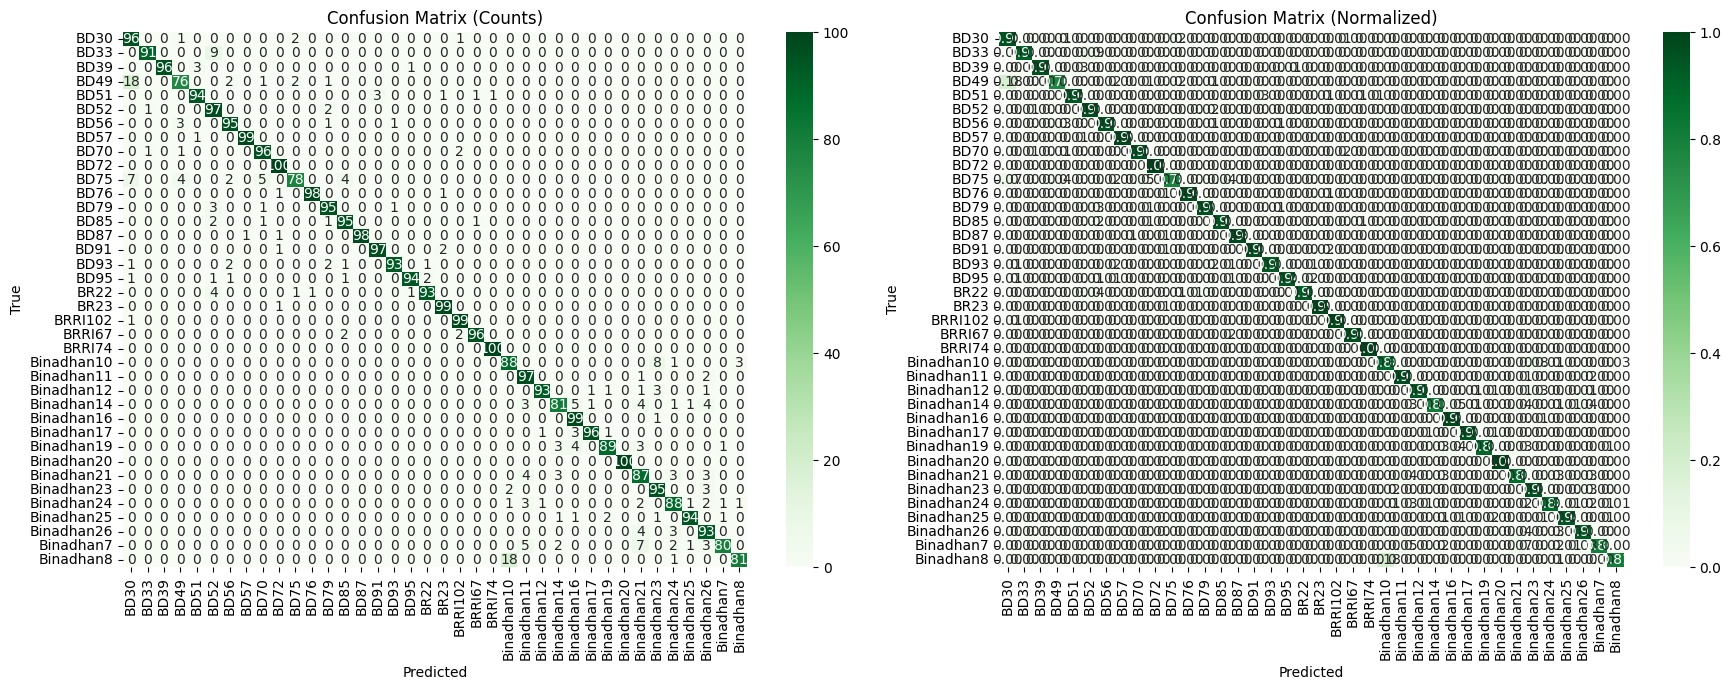

In [13]:
# === Part 12: Confusion Matrix (Counts & Normalized) ===
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
axes[1].set_title("Confusion Matrix (Normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "confusion_matrix_counts_normalized.png"), dpi=150)
plt.show()


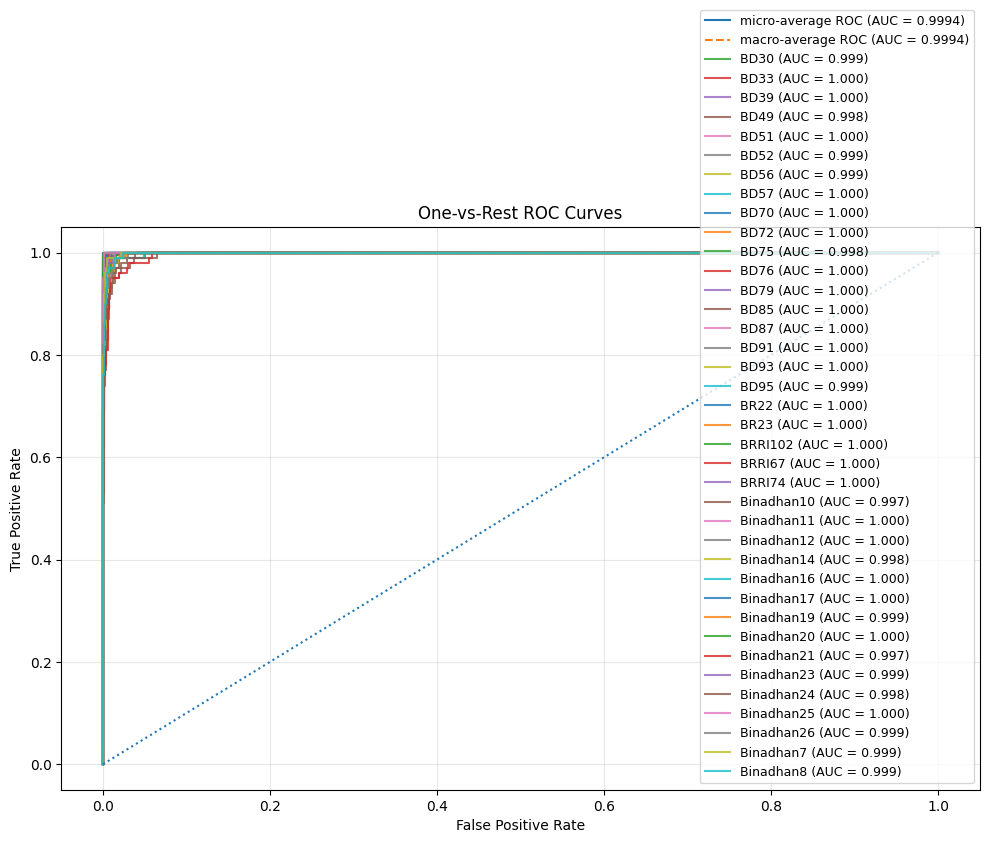

In [14]:
# === Part 13: ROC & AUC (One-vs-Rest, Micro, Macro) ===
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))  # (N, C)

fpr = {}; tpr = {}; roc_auc = {}
for c in range(num_classes):
    fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_prob[:, c])
    roc_auc[c] = auc(fpr[c], tpr[c])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[c] for c in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for c in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], linestyle='-', label=f"micro-average ROC (AUC = {roc_auc['micro']:.4f})")
plt.plot(all_fpr,   mean_tpr,        linestyle='--', label=f"macro-average ROC (AUC = {roc_auc['macro']:.4f})")

# Show ROC for *every* class
for c in range(num_classes):
    plt.plot(fpr[c], tpr[c], label=f"{class_names[c]} (AUC = {roc_auc[c]:.3f})", alpha=0.8)

plt.plot([0, 1], [0, 1], linestyle=':')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "roc_ovr_micro_macro.png"), dpi=150)
plt.show()


K-Means on encoder features -> ARI: 0.6037 | NMI: 0.7913 | Silhouette: 0.1581
Running t-SNE...


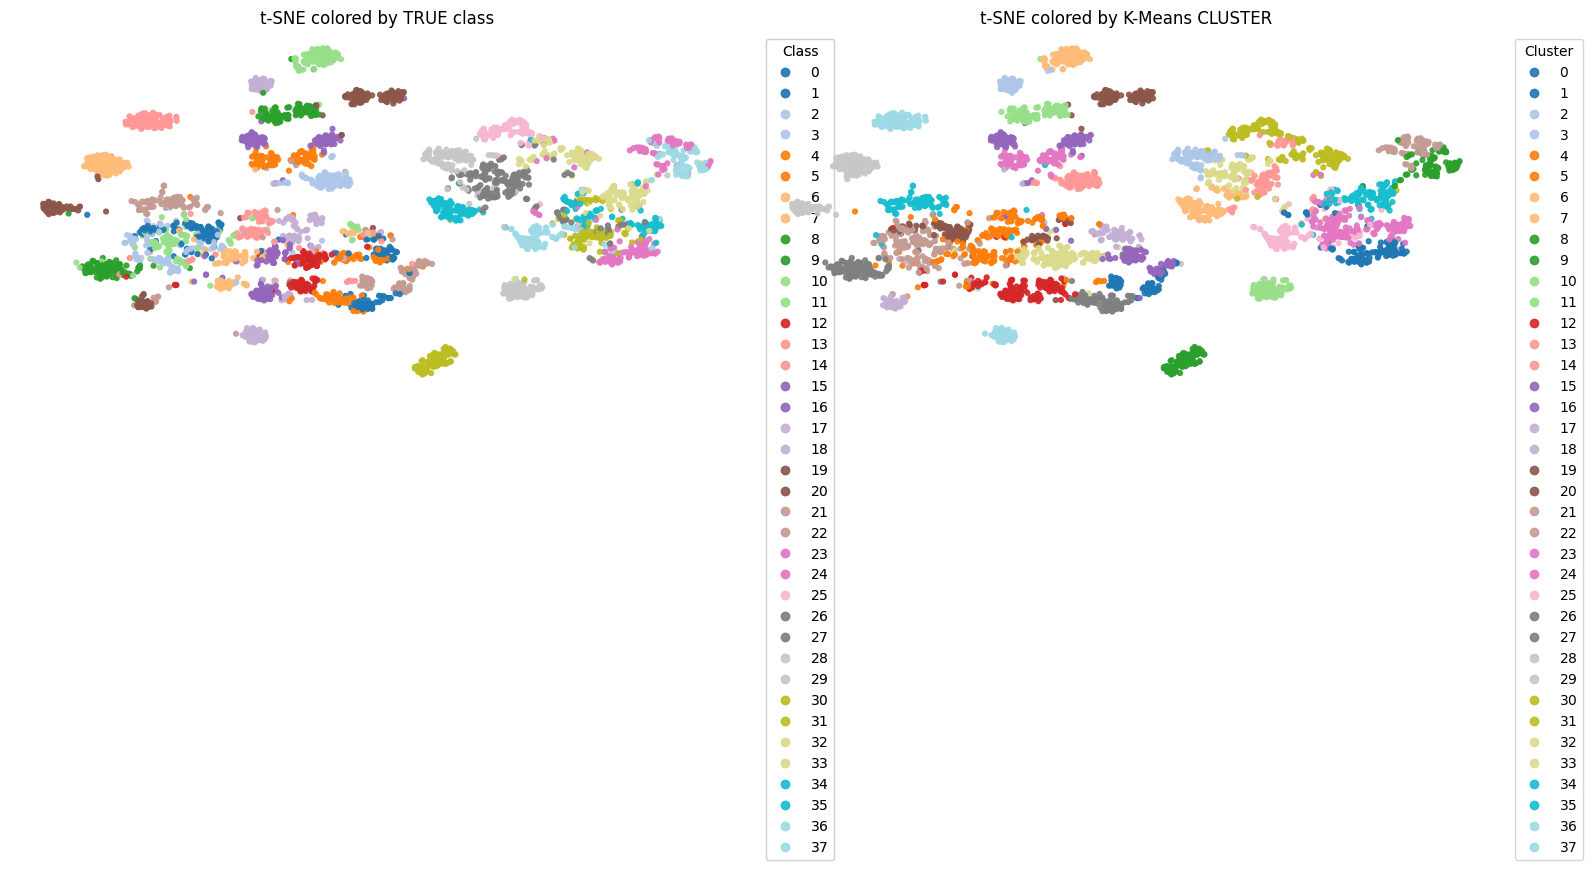

In [15]:
# === Part 14: Clustering on encoder features ===
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.manifold import TSNE

@torch.no_grad()
def extract_features_only(model, loader, device):
    model.eval()
    feats, labels = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        f = model.encoder(x)
        feats.append(f.cpu().numpy()); labels.append(y.numpy())
    return np.concatenate(feats, 0), np.concatenate(labels, 0)

features, labels = extract_features_only(sup_model, test_loader_sup, DEVICE)
features_norm = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-9)

kmeans = KMeans(n_clusters=num_classes, n_init=20, random_state=SEED)
clusters = kmeans.fit_predict(features_norm)

ari = adjusted_rand_score(labels, clusters)
nmi = normalized_mutual_info_score(labels, clusters)
sil = silhouette_score(features_norm, clusters)
print(f"K-Means on encoder features -> ARI: {ari:.4f} | NMI: {nmi:.4f} | Silhouette: {sil:.4f}")

print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=min(30, max(5, len(labels)//20)), init='pca', random_state=SEED)
emb2d = tsne.fit_transform(features_norm)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
scatter1 = axes[0].scatter(emb2d[:,0], emb2d[:,1], c=labels, s=12, alpha=0.9, cmap='tab20')
axes[0].set_title("t-SNE colored by TRUE class"); axes[0].axis('off')
legend1 = axes[0].legend(*scatter1.legend_elements(num=num_classes), title="Class", bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].add_artist(legend1)

scatter2 = axes[1].scatter(emb2d[:,0], emb2d[:,1], c=clusters, s=12, alpha=0.9, cmap='tab20')
axes[1].set_title("t-SNE colored by K-Means CLUSTER"); axes[1].axis('off')
legend2 = axes[1].legend(*scatter2.legend_elements(num=num_classes), title="Cluster", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "tsne_true_vs_cluster.png"), dpi=150)
plt.show()


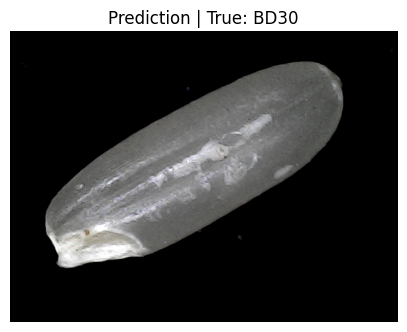

Top-k probabilities:
                BD30: 0.9873
                BD85: 0.0034
              BRRI67: 0.0033
                BR22: 0.0011
                BD52: 0.0010


In [16]:
# === Part 15: Single Image Validation Demo ===
from PIL import Image

img_path = None  # e.g., "/kaggle/input/riceds-original/Original/classX/img123.jpg"

if img_path is None:
    import random
    rnd_idx = random.choice(range(len(test_sup)))
    pil_img_transformed, true_label = test_sup[rnd_idx]
    raw_path, raw_lbl = sup_test_ds.samples[test_idx[rnd_idx]]
    rgb_img = Image.open(raw_path).convert("RGB")
    tensor_img = eval_tf(rgb_img).unsqueeze(0).to(DEVICE)
else:
    rgb_img = Image.open(img_path).convert("RGB")
    tensor_img = eval_tf(rgb_img).unsqueeze(0).to(DEVICE)
    true_label = None

sup_model.eval()
with torch.no_grad():
    logits = (predict_tta(sup_model, tensor_img) if USE_TTA else sup_model(tensor_img))
    probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()

topk = min(5, num_classes)
top_idx = np.argsort(-probs)[:topk]
top_pairs = [(class_names[i], float(probs[i])) for i in top_idx]

plt.figure(figsize=(5,5))
plt.imshow(rgb_img); plt.axis('off')
title = "Prediction"
if true_label is not None:
    title += f" | True: {class_names[true_label]}"
plt.title(title)
plt.show()

print("Top-k probabilities:")
for name, p in top_pairs:
    print(f"{name:>20s}: {p:.4f}")


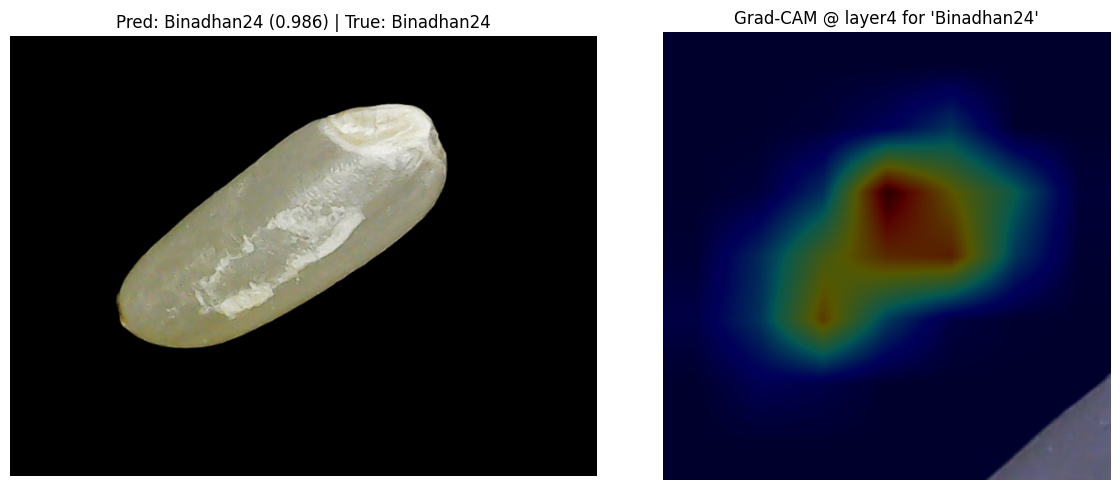

Top-k probabilities:
          Binadhan24: 0.9862
          Binadhan26: 0.0041
          Binadhan10: 0.0030
          Binadhan11: 0.0029
          Binadhan23: 0.0005


In [17]:
# === Part 16: Grad-CAM (single image) ===
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

GRADCAM_TARGET = 'layer4'
TOPK_TO_PRINT = 5
gradcam_img_path = None

class GradCAM:
    def __init__(self, model: nn.Module, target_module: nn.Module):
        self.model = model
        self.target_module = target_module
        self.activations = None
        self.gradients = None
        self.fwd_handle = target_module.register_forward_hook(self._forward_hook)
        self.bwd_handle = target_module.register_full_backward_hook(self._backward_hook)
    def _forward_hook(self, module, inputs, output): self.activations = output.detach()
    def _backward_hook(self, module, grad_input, grad_output): self.gradients = grad_output[0].detach()
    def remove(self): self.fwd_handle.remove(); self.bwd_handle.remove()
    def generate(self, logits, class_idx: int):
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        B, _, H, W = cam.shape
        cam = cam.view(B, -1)
        cam -= cam.min(dim=1, keepdim=True).values
        cam /= (cam.max(dim=1, keepdim=True).values + 1e-9)
        return cam.view(B, 1, H, W)

def get_target_conv_module(sup_model: nn.Module, target_name='layer4'):
    return sup_model.encoder.backbone[7]  # ResNet50 layer4

if gradcam_img_path is None:
    import random
    rnd_idx = random.choice(range(len(test_sup)))
    pil_img_transformed, true_label = test_sup[rnd_idx]
    raw_path, raw_lbl = sup_test_ds.samples[test_idx[rnd_idx]]
    rgb_img = Image.open(raw_path).convert("RGB")
    input_tensor = eval_tf(rgb_img).unsqueeze(0).to(DEVICE)
else:
    rgb_img = Image.open(gradcam_img_path).convert("RGB")
    input_tensor = eval_tf(rgb_img).unsqueeze(0).to(DEVICE)
    true_label = None

sup_model.eval()
target_module = get_target_conv_module(sup_model, GRADCAM_TARGET)
cam_engine = GradCAM(sup_model, target_module)

with torch.enable_grad():
    input_tensor.requires_grad_(True)
    logits = sup_model(input_tensor)  # No TTA for CAM
    probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
    pred_idx = int(np.argmax(probs))
    target_idx = pred_idx
    sup_model.zero_grad(set_to_none=True)
    score = logits[0, target_idx]
    score.backward()
    cam = cam_engine.generate(logits, target_idx)[0, 0]
    cam_engine.remove()

cam_np = cam.cpu().numpy()
H_img, W_img = input_tensor.shape[-2], input_tensor.shape[-1]
cam_up = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(H_img, W_img), mode='bilinear', align_corners=False)[0,0].cpu().numpy()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(rgb_img); plt.axis('off')
title = f"Pred: {class_names[pred_idx]} ({probs[pred_idx]:.3f})"
if true_label is not None:
    title += f" | True: {class_names[true_label]}"
plt.title(title)
plt.subplot(1,2,2)
plt.imshow(rgb_img); 
plt.imshow(cam_up, cmap='jet', alpha=0.35, interpolation='nearest')
plt.axis('off')
plt.title(f"Grad-CAM @ {GRADCAM_TARGET} for '{class_names[target_idx]}'")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "gradcam_overlay.png"), dpi=150)
plt.show()

topk = min(TOPK_TO_PRINT, len(class_names))
top_idx = np.argsort(-probs)[:topk]
print("Top-k probabilities:")
for i in top_idx:
    print(f"{class_names[i]:>20s}: {probs[i]:.4f}")


In [18]:
# === Part 16A: Grad-CAM per-class summary (correct & incorrect) ===
import os, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

OUT_DIR = os.path.join(SAVE_DIR, "gradcam_per_class")
os.makedirs(OUT_DIR, exist_ok=True)
N_PER_CLASS_CORRECT = 1
N_PER_CLASS_INCORRECT = 1

class GradCAM:
    def __init__(self, model: nn.Module, target_module: nn.Module):
        self.model = model; self.target_module = target_module
        self.activations = None; self.gradients = None
        self.fwd = target_module.register_forward_hook(self._fwd_hook)
        self.bwd = target_module.register_full_backward_hook(self._bwd_hook)
    def _fwd_hook(self, m, i, o): self.activations = o.detach()
    def _bwd_hook(self, m, gi, go): self.gradients = go[0].detach()
    def remove(self): self.fwd.remove(); self.bwd.remove()
    def generate(self, target_idx):
        w = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (w * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        B = cam.shape[0]
        cam = cam.view(B, -1); cam -= cam.min(dim=1, keepdim=True).values
        cam /= (cam.max(dim=1, keepdim=True).values + 1e-9)
        return cam.view(-1, 1, self.activations.shape[2], self.activations.shape[3])

def get_target_conv_module(sup_model: nn.Module, name='layer4'):
    return sup_model.encoder.backbone[7]

def overlay_and_save(rgb_img, cam_upsampled, title, fpath):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(rgb_img); plt.axis('off'); plt.title(title)
    plt.subplot(1,2,2); plt.imshow(rgb_img); plt.imshow(cam_upsampled, cmap='jet', alpha=0.35); plt.axis('off'); plt.title("Grad-CAM")
    plt.tight_layout(); plt.savefig(fpath, dpi=150); plt.close()

cands_correct = {c: [] for c in range(len(class_names))}
cands_incorrect = {c: [] for c in range(len(class_names))}

sup_model.eval()
test_samples = [sup_test_ds.samples[i] for i in test_idx]

for idx_in_subset, (x_t, y_t) in enumerate(tqdm(test_loader_sup, desc="Scanning test set")):
    for j in range(x_t.size(0)):
        global_j = idx_in_subset * test_loader_sup.batch_size + j
        if global_j >= len(test_samples): break
        raw_path, true_lbl = test_samples[global_j]
        x = x_t[j:j+1].to(DEVICE, non_blocking=True)
        probs = F.softmax(sup_model(x), dim=1)[0].detach().cpu().numpy()
        pred = int(np.argmax(probs)); conf = float(probs[pred])
        entry = (conf, raw_path, true_lbl, pred)
        if pred == true_lbl: cands_correct[true_lbl].append(entry)
        else:                cands_incorrect[true_lbl].append(entry)

for c in range(len(class_names)):
    cands_correct[c].sort(key=lambda t: -t[0])
    cands_incorrect[c].sort(key=lambda t: -t[0])

target_module = get_target_conv_module(sup_model, 'layer4')
for c in range(len(class_names)):
    # Corrects
    sel_correct = cands_correct[c][:N_PER_CLASS_CORRECT] if N_PER_CLASS_CORRECT is not None else cands_correct[c]
    for k, entry in enumerate(sel_correct):
        conf, raw_path, true_lbl, pred = entry
        rgb = Image.open(raw_path).convert("RGB")
        x = eval_tf(rgb).unsqueeze(0).to(DEVICE)
        cam_engine = GradCAM(sup_model, target_module)
        with torch.enable_grad():
            x.requires_grad_(True)
            logits = sup_model(x)
            score = logits[0, pred]
            sup_model.zero_grad(set_to_none=True)
            score.backward()
            cam = cam_engine.generate(pred)[0,0]
            cam_engine.remove()
        cam_up = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=x.shape[-2:], mode='bilinear', align_corners=False)[0,0].cpu().numpy()
        title = f"TRUE={class_names[true_lbl]} | PRED={class_names[pred]} ({conf:.3f}) [correct]"
        fpath = os.path.join(OUT_DIR, f"class{c:02d}_correct_{k}.png"); overlay_and_save(rgb, cam_up, title, fpath)

    # Incorrects
    sel_incorrect = cands_incorrect[c][:N_PER_CLASS_INCORRECT] if N_PER_CLASS_INCORRECT is not None else cands_incorrect[c]
    for k, entry in enumerate(sel_incorrect):
        conf, raw_path, true_lbl, pred = entry
        rgb = Image.open(raw_path).convert("RGB")
        x = eval_tf(rgb).unsqueeze(0).to(DEVICE)
        cam_engine = GradCAM(sup_model, target_module)
        with torch.enable_grad():
            x.requires_grad_(True)
            logits = sup_model(x)
            score = logits[0, pred]
            sup_model.zero_grad(set_to_none=True)
            score.backward()
            cam = cam_engine.generate(pred)[0,0]
            cam_engine.remove()
        cam_up = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=x.shape[-2:], mode='bilinear', align_corners=False)[0,0].cpu().numpy()
        title = f"TRUE={class_names[true_lbl]} | PRED={class_names[pred]} ({conf:.3f}) [incorrect]"
        fpath = os.path.join(OUT_DIR, f"class{c:02d}_incorrect_{k}.png"); overlay_and_save(rgb, cam_up, title, fpath)

print(f"Saved per-class Grad-CAM overlays to: {OUT_DIR}")


Scanning test set: 100%|██████████| 60/60 [00:32<00:00,  1.84it/s]


Saved per-class Grad-CAM overlays to: ./gradcam_per_class


In [19]:
# === Part 16D: Percent "good" Grad-CAM via deletion test + sanity rates ===
import numpy as np, torch, torch.nn.functional as F
from tqdm import tqdm
import math

# minimal Grad-CAM if not present
if 'GradCAM' not in globals():
    class GradCAM:
        def __init__(self, model: nn.Module, target_module: nn.Module):
            self.model = model; self.target_module = target_module
            self.activations = None; self.gradients = None
            self.fwd = target_module.register_forward_hook(self._fh)
            self.bwd = target_module.register_full_backward_hook(self._bh)
        def _fh(self, m,i,o): self.activations = o.detach()
        def _bh(self, m,gi,go): self.gradients = go[0].detach()
        def remove(self): self.fwd.remove(); self.bwd.remove()
        def generate(self, class_idx: int):
            w = self.gradients.mean(dim=(2,3), keepdim=True)
            cam = (w * self.activations).sum(dim=1, keepdim=True)
            cam = F.relu(cam)
            B,_,H,W = cam.shape
            cam = cam.view(B,-1); cam -= cam.min(dim=1, keepdim=True).values
            cam /= (cam.max(dim=1, keepdim=True).values + 1e-9)
            return cam.view(-1,1,H,W)

def _get_target_conv_module(m):   # ResNet50 layer4 in your encoder
    return m.encoder.backbone[7]

@torch.no_grad()
def _predict(model, x):
    logits = model(x)
    probs = F.softmax(logits, dim=1)
    conf, pred = probs.max(dim=1)
    return probs, conf, pred

def _cam_up(model, x1, class_idx):
    tgt = _get_target_conv_module(model)
    engine = GradCAM(model, tgt)
    with torch.enable_grad():
        x = x1.clone().requires_grad_(True)
        logits = model(x)
        score = logits[0, class_idx]
        model.zero_grad(set_to_none=True)
        score.backward()
        cam = engine.generate(class_idx)[0,0]
    engine.remove()
    return F.interpolate(cam[None,None], size=x1.shape[-2:], mode='bilinear', align_corners=False)[0,0].detach()

def _top_frac_mask(cam_np, frac):
    H,W = cam_np.shape
    flat = cam_np.reshape(-1)
    k = max(1, int(math.ceil(frac * flat.size)))
    thresh = np.partition(flat, -k)[-k]
    return (cam_np >= thresh).astype(np.float32)

def _apply_mask_zero(x1, mask_np):
    m = torch.from_numpy(mask_np).to(x1.device).view(1,1,*x1.shape[-2:])
    return x1 * (1 - m)

def _cos_sim(a, b):
    a = a.reshape(-1); b = b.reshape(-1)
    a = a / (np.linalg.norm(a) + 1e-9); b = b / (np.linalg.norm(b) + 1e-9)
    return float((a*b).sum())

# ---------- CONFIG ----------
N_SAMPLES = min(120, len(test_loader_sup.dataset))  # how many test images to score
FRACS = np.linspace(0.05, 0.5, 10)                  # deletion curve points (5%..50%)
MARGIN = 0.02                                       # advantage over random to count as "good"
FLIP_TAU = 0.70                                     # pass if cosine(orig, unflip(flip)) >= 0.70
SENS_TAU = 0.60                                     # pass if cosine(predCAM, nextBestCAM) <= 0.60

# ---------- collect a sample pool ----------
samples = []
cnt = 0
for xb, yb in test_loader_sup:
    for i in range(xb.size(0)):
        samples.append((xb[i:i+1].to(DEVICE), int(yb[i].item())))
        cnt += 1
        if cnt >= N_SAMPLES: break
    if cnt >= N_SAMPLES: break

sup_model.eval()

good_count = 0
good_auc_count = 0
flip_pass = 0
sens_pass = 0

auc_gaps = []
mean_gaps = []

for x1, _ in tqdm(samples, desc="Scoring Grad-CAM quality"):
    probs, conf, pred = _predict(sup_model, x1)
    cls = int(pred.item()); base_p = float(probs[0, cls].item())

    cam = _cam_up(sup_model, x1, cls).cpu().numpy()

    drops_cam = []
    drops_rand = []
    for f in FRACS:
        M = _top_frac_mask(cam, f)
        x_cam = _apply_mask_zero(x1, M)
        p_cam = float(_predict(sup_model, x_cam)[0][0, cls].item())
        drops_cam.append(base_p - p_cam)

        M_r = np.zeros_like(M)
        flat = M_r.reshape(-1); k = int(M.sum())
        ridx = np.random.choice(flat.size, size=k, replace=False)
        flat[ridx] = 1.0; M_r = flat.reshape(M_r.shape)
        x_r = _apply_mask_zero(x1, M_r)
        p_r = float(_predict(sup_model, x_r)[0][0, cls].item())
        drops_rand.append(base_p - p_r)

    drops_cam = np.array(drops_cam); drops_rand = np.array(drops_rand)

    mean_gap = float(np.mean(drops_cam - drops_rand))
    auc_cam  = float(np.trapz(drops_cam, FRACS))
    auc_rand = float(np.trapz(drops_rand, FRACS))
    auc_gap  = auc_cam - auc_rand

    mean_gaps.append(mean_gap); auc_gaps.append(auc_gap)
    if mean_gap > MARGIN: good_count += 1
    if auc_gap  > 0.0:    good_auc_count += 1

    # Flip-consistency
    c = cls
    cam_orig = cam
    cam_flip = _cam_up(sup_model, torch.flip(x1, dims=[3]), c).cpu().numpy()
    cam_flip_unflip = cam_flip[:, ::-1]
    if _cos_sim(cam_orig, cam_flip_unflip) >= FLIP_TAU: flip_pass += 1

    # Class-sensitivity
    with torch.no_grad():
        pr = F.softmax(sup_model(x1), dim=1)[0].cpu().numpy()
        order = np.argsort(-pr)
    c1 = int(order[0]); c2 = int(order[1]) if len(order) > 1 else c1
    cam2 = _cam_up(sup_model, x1, c2).cpu().numpy()
    if _cos_sim(cam_orig, cam2) <= SENS_TAU: sens_pass += 1

N_eval = len(samples)
pct_good_mean = 100.0 * good_count / N_eval
pct_good_auc  = 100.0 * good_auc_count / N_eval
pct_flip_pass = 100.0 * flip_pass / N_eval
pct_sens_pass = 100.0 * sens_pass / N_eval

print("\n=== Grad-CAM quality summary ===")
print(f"Samples evaluated: {N_eval}")
print(f"• Deletion (mean-gap > {MARGIN:.2f})     → GOOD %: {pct_good_mean:.1f}")
print(f"• Deletion (AUC_cam > AUC_rand)          → GOOD %: {pct_good_auc:.1f}")
print(f"• Flip-consistency (cos ≥ {FLIP_TAU:.2f}) → PASS %: {pct_flip_pass:.1f}")
print(f"• Class-sensitivity (cos ≤ {SENS_TAU:.2f})→ PASS %: {pct_sens_pass:.1f}")

print("\nTip: prioritize the Deletion AUC GOOD % as your primary number.\n"
      "Adjust MARGIN/FLIP_TAU/SENS_TAU if you want stricter or looser criteria.")


Scoring Grad-CAM quality: 100%|██████████| 120/120 [00:30<00:00,  3.94it/s]


=== Grad-CAM quality summary ===
Samples evaluated: 120
• Deletion (mean-gap > 0.02)     → GOOD %: 9.2
• Deletion (AUC_cam > AUC_rand)          → GOOD %: 10.0
• Flip-consistency (cos ≥ 0.70) → PASS %: 97.5
• Class-sensitivity (cos ≤ 0.60)→ PASS %: 60.8

Tip: prioritize the Deletion AUC GOOD % as your primary number.
Adjust MARGIN/FLIP_TAU/SENS_TAU if you want stricter or looser criteria.
